# Imports

In [1]:
## Imports ##
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from utility import save_features, load_features, showFeatures, save_gridsearch_results, load_gridsearch_results
from feature_selection import FeatureSelectorByModel
from sklearn.metrics import confusion_matrix, classification_report
from comparison import compare_binary_models_split, compare_multiclass_models_split
from randforest_optimization import random_forest_multiclass_optimization
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline
from preprocessing import KDD99Preprocessor
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Introduction
## Dataset analysis

In [2]:
## Read the dataset ##
df = pd.read_csv("datasets/kddcup99_csv.csv")
df = df.drop_duplicates()
print(df.info())
#df=df.head(5000)

<class 'pandas.core.frame.DataFrame'>
Index: 145586 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     145586 non-null  int64  
 1   protocol_type                145586 non-null  object 
 2   service                      145586 non-null  object 
 3   flag                         145586 non-null  object 
 4   src_bytes                    145586 non-null  int64  
 5   dst_bytes                    145586 non-null  int64  
 6   land                         145586 non-null  int64  
 7   wrong_fragment               145586 non-null  int64  
 8   urgent                       145586 non-null  int64  
 9   hot                          145586 non-null  int64  
 10  num_failed_logins            145586 non-null  int64  
 11  logged_in                    145586 non-null  int64  
 12  lnum_compromised             145586 non-null  int64  
 13  lroo

In [3]:
y = df['label']
print(y.value_counts())

label
normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: count, dtype: int64


## Data Preprocessing

In [4]:
# Filter out class with less than 20 samples to allow SMOTE and other methods to work effectively
min_samples = 20
value_counts = y.value_counts()
valid_classes = value_counts[value_counts >= min_samples].index
mask = y.isin(valid_classes)
X_filtered = df[mask]
y_filtered = y[mask]

In [5]:
X_filtered = X_filtered.drop(columns=['label'])

# y_multiclass is the multiclass classification target variable
y_multiclass = y_filtered
# y_bin is the binary classification target variable
y_bin = y_filtered.apply(lambda x: 1 if x == 'normal.' else 0)
print(y_bin.value_counts())

label
1    87832
0    57680
Name: count, dtype: int64


# Pipeline study and creation

## Finding best classifier

Random Forest: F1 macro (CV) = 0.954 ± 0.020
Logistic Regression: F1 macro (CV) = 0.855 ± 0.072
SVM: F1 macro (CV) = 0.760 ± 0.028

Risultati comparativi cross-validation:
               Modello  F1 macro mean  F1 macro std
0        Random Forest       0.954182      0.019894
1  Logistic Regression       0.855197      0.071792
2                  SVM       0.760265      0.028121


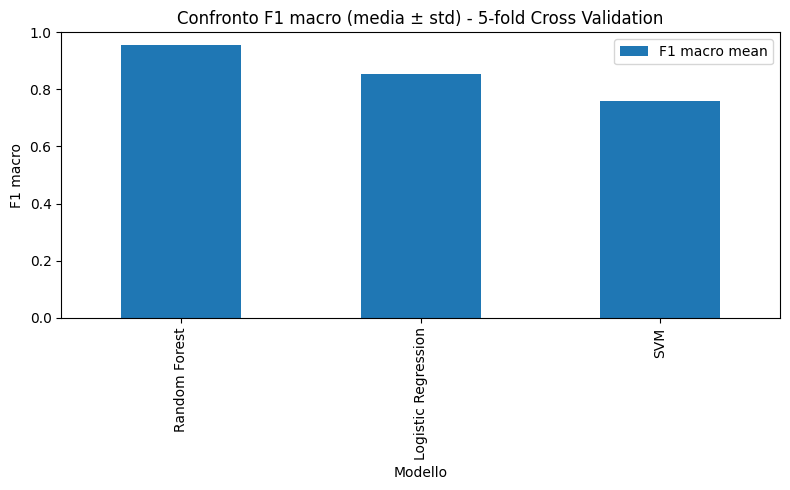

In [6]:
pipelines = {
    "Random Forest": Pipeline([
        ('preprocessing', KDD99Preprocessor()),
        ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.3, n_rf_fit=1)),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=2))
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessing', KDD99Preprocessor()),
        ('feature_selection', FeatureSelectorByModel(model_type='logreg', n_features=20, n_rf_fit=1)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "SVM": Pipeline([
        ('preprocessing', KDD99Preprocessor()),
        ('feature_selection', FeatureSelectorByModel(model_type='svm', n_features=20, n_rf_fit=1)),
        ('classifier', LinearSVC(dual=False, max_iter=2000, random_state=42))
    ])
}


# Step 3: cross-validation stratificata
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_filtered, y_multiclass, cv=skf, scoring='f1_macro', n_jobs=-1)
    results.append({
        "Modello": name,
        "F1 macro mean": scores.mean(),
        "F1 macro std": scores.std()
    })
    print(f"{name}: F1 macro (CV) = {scores.mean():.3f} ± {scores.std():.3f}")

# DataFrame ordinato per presentazione/report
df_results = pd.DataFrame(results)
print("\nRisultati comparativi cross-validation:")
print(df_results.sort_values("F1 macro mean", ascending=False))

# Barplot per report/slide
df_results.set_index("Modello")[["F1 macro mean"]].plot(kind='bar', yerr=df_results["F1 macro std"], capsize=4, figsize=(8,5))
plt.title("Confronto F1 macro (media ± std) - 5-fold Cross Validation")
plt.ylabel("F1 macro")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Optimization with smote and grid search

In [9]:
import json
import os

if os.path.exists("best_rf_params.json"):
  best_params, best_score, cv_results = load_gridsearch_results(prefix="rf")
else:
  print("File 'best_rf_params.json' not found.")


In [10]:
# 1. Costruisci la pipeline con SMOTE, feature selection e RF
rf_pipeline = Pipeline([
    ('preprocessing', KDD99Preprocessor()),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.4, n_rf_fit=1)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=2))
])

# 2. Definisci la griglia di parametri da ottimizzare
param_grid = {
    'rf__n_estimators': [100],
    'rf__max_depth': [10, None],
    'rf__class_weight': [None, 'balanced']
}

# Sample
SAMPLE_SIZE = 10000
sample_idx = np.random.choice(len(X_filtered), size=SAMPLE_SIZE, replace=False)
X_sample = X_filtered.iloc[sample_idx]
y_sample = y_multiclass.iloc[sample_idx]

# Da togliere quando si scommenta il blocco sopra
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 4. GridSearchCV per trovare la combinazione migliore
grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

# 5. Fit e valutazione su tutto il dataset (y_multiclass già filtrato se necessario)

if 'best_params' not in locals():
  grid.fit(X_filtered, y_multiclass)
  best_params = grid.best_params_
  best_score = grid.best_score_
  cv_results = grid.cv_results_
else:
  print("I migliori parametri sono già stati caricati. Salta la fase di calcolo.")

print("\nMigliori parametri trovati:", best_params)
print("F1 macro migliore (CV):", best_score)

# 6. Analisi risultati
import pandas as pd
cv_results = pd.DataFrame(cv_results)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
print(cv_results[['params', 'mean_test_score', 'std_test_score']].head(10))

I migliori parametri sono già stati caricati. Salta la fase di calcolo.

Migliori parametri trovati: {'rf__class_weight': None, 'rf__max_depth': None, 'rf__n_estimators': 100}
F1 macro migliore (CV): 0.9667415372766829
                                              params  mean_test_score  \
1  {'rf__class_weight': None, 'rf__max_depth': No...         0.966742   
3  {'rf__class_weight': 'balanced', 'rf__max_dept...         0.966742   
0  {'rf__class_weight': None, 'rf__max_depth': 10...         0.899870   
2  {'rf__class_weight': 'balanced', 'rf__max_dept...         0.899870   

   std_test_score  
1        0.012117  
3        0.012117  
0        0.017595  
2        0.017595  


In [11]:
import json
if 'grid' in locals() and hasattr(grid, 'best_params_'):
  save_gridsearch_results(grid, prefix="rf")
  print("Grid search results saved successfully.")
else:
  print("Grid search not recalculated and results not found. Skipping save operation.")

Grid search not recalculated and results not found. Skipping save operation.


# Binary classification

In [13]:
# Split train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_bin, test_size=0.25, stratify=y_bin, random_state=42)

# Prepara pipeline (con best_params già caricati)
rf_best_params = {k.replace("rf__", ""): v for k, v in best_params.items()}
pipeline = Pipeline([
    ('preprocessing', KDD99Preprocessor()),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.3)),
    ('rf', RandomForestClassifier(**rf_best_params, random_state=42))
])

# Fit
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]  # per ROC/AUC

# Report numerico
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))


Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00     14420
      Normal       1.00      1.00      1.00     21958

    accuracy                           1.00     36378
   macro avg       1.00      1.00      1.00     36378
weighted avg       1.00      1.00      1.00     36378



## Visualizing results

### Confusion Matrix

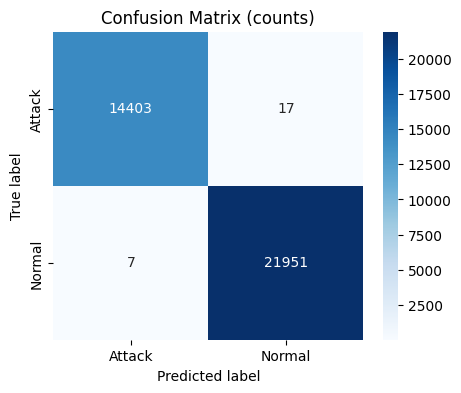

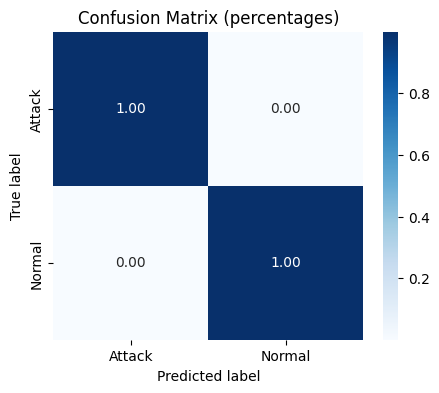

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix (counts)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix (percentages)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


### ROC + AUC

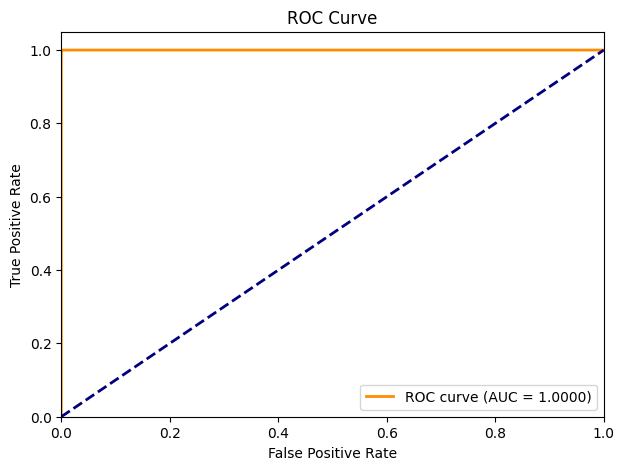

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


### Precision-Recall Curve

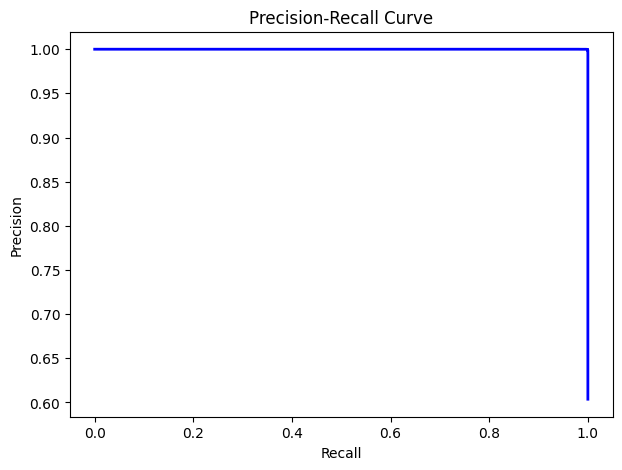

Area under Precision-Recall curve: 1.0000


In [16]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, lw=2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Area sotto la curva PR
pr_auc = auc(recall, precision)
print(f"Area under Precision-Recall curve: {pr_auc:.4f}")


### Barplot

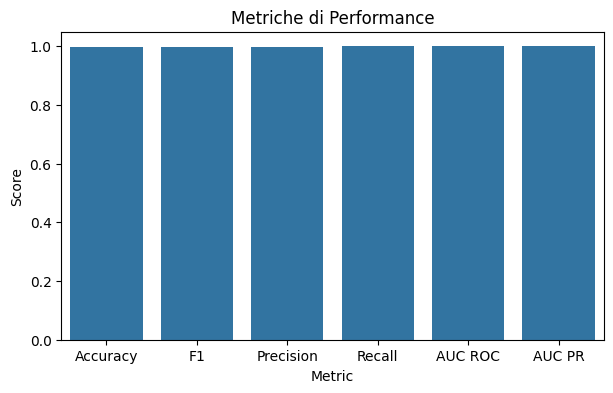

In [17]:
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'AUC ROC': roc_auc,
    'AUC PR': pr_auc
}
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

plt.figure(figsize=(7,4))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.ylim(0, 1.05)
plt.title("Metriche di Performance")
plt.show()


In [19]:
# Rimuovi 'rf__' dal nome dei parametri se necessario
rf_best_params = {k.replace('rf__', ''): v for k, v in best_params.items()}

# 2. Prepara i fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_filtered, y_multiclass)):
    print(f"Fold {fold + 1}/5")
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_multiclass.iloc[train_idx], y_multiclass.iloc[test_idx]
    
    # 3. Allena la pipeline sui dati di train di questo fold
    fold_pipeline = Pipeline([
        ('preprocessing', KDD99Preprocessor()),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', FeatureSelectorByModel(model_type='rf', threshold=0.3)),
        ('rf', RandomForestClassifier(**rf_best_params, random_state=42))
    ])
    fold_pipeline.fit(X_train, y_train)
    
    # 4. Predici sui dati di test di questo fold (out of fold)
    y_pred = fold_pipeline.predict(X_test)
    
    # 5. Accumula le predizioni
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# 6. Concatena tutte le predizioni per fare confusion matrix e classification report
labels = np.unique(y_multiclass)
cm = confusion_matrix(y_true_all, y_pred_all, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("\nConfusion matrix aggregata su CV (out-of-fold):")
print(cm_df)

# 7. Report dettagliato (precision, recall, f1 per ogni classe)
print("\nClassification report cross-validated:")
print(classification_report(y_true_all, y_pred_all, labels=labels, zero_division=0))


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Confusion matrix aggregata su CV (out-of-fold):
                  back.  buffer_overflow.  guess_passwd.  ipsweep.  neptune.  \
back.               967                 0              0         0         0   
buffer_overflow.      0                24              0         0         0   
guess_passwd.         0                 0             50         0         0   
ipsweep.              0                 0              0       646         0   
neptune.              0                 0              0         0     51817   
nmap.                 0                 0              0         1         0   
normal.               0                 3              0         4         3   
pod.                  0                 0              0         0         0   
portsweep.            0                 0              0         1         1   
satan.                0                 0              0         1         1   
smurf.                0   

## Visualizing results

### Confusion matrix normalized

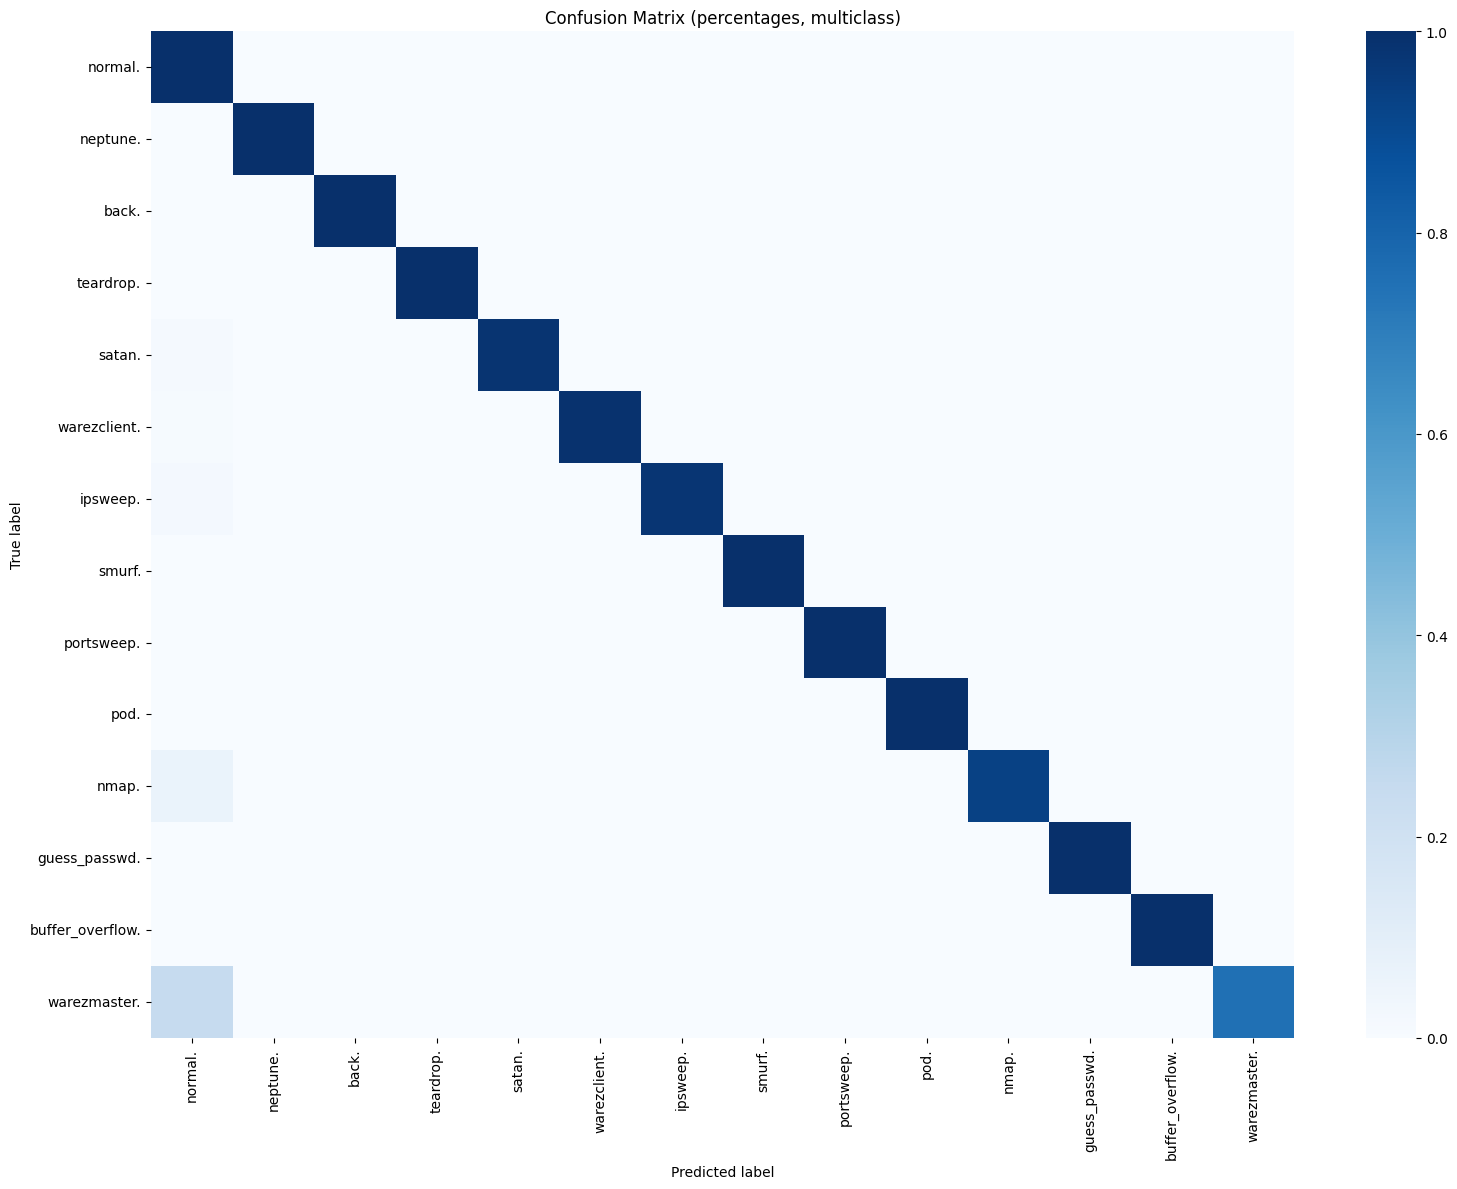

In [20]:
# Ordina le classi per supporto (così la heatmap è più leggibile)
labels_sorted = y_test.value_counts().index.tolist()
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_norm, annot=False, cmap='Blues',
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.title("Confusion Matrix (percentages, multiclass)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


### Barplot F1, Precision, Recall per classe

C:\Users\feder\AppData\Local\Temp\ipykernel_18968\2480776343.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1', data=results_df, palette="mako")


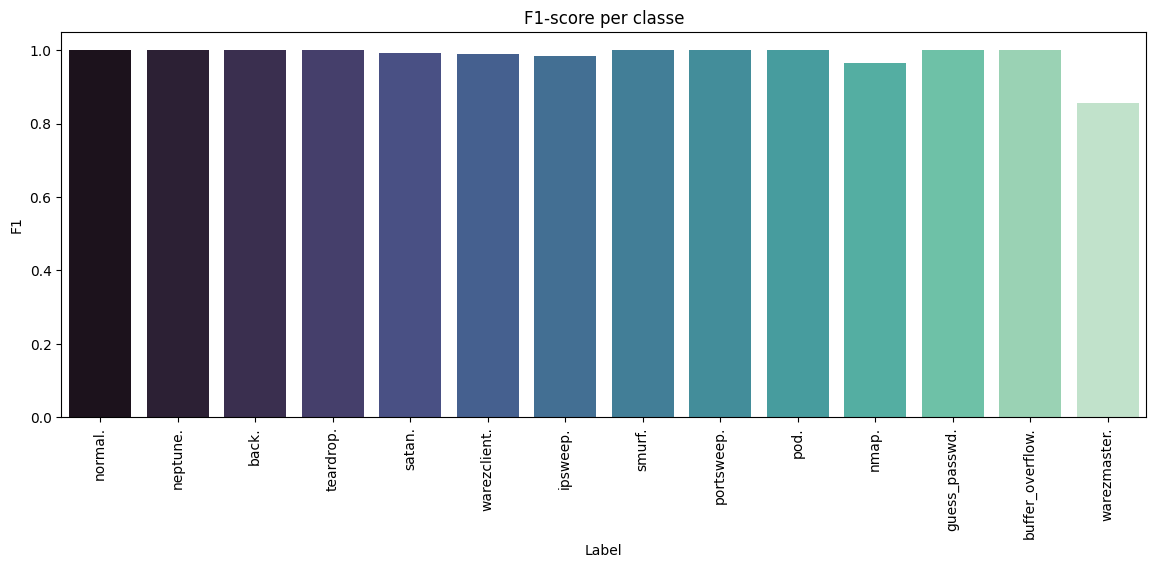

C:\Users\feder\AppData\Local\Temp\ipykernel_18968\2480776343.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Recall', data=results_df, palette="crest")


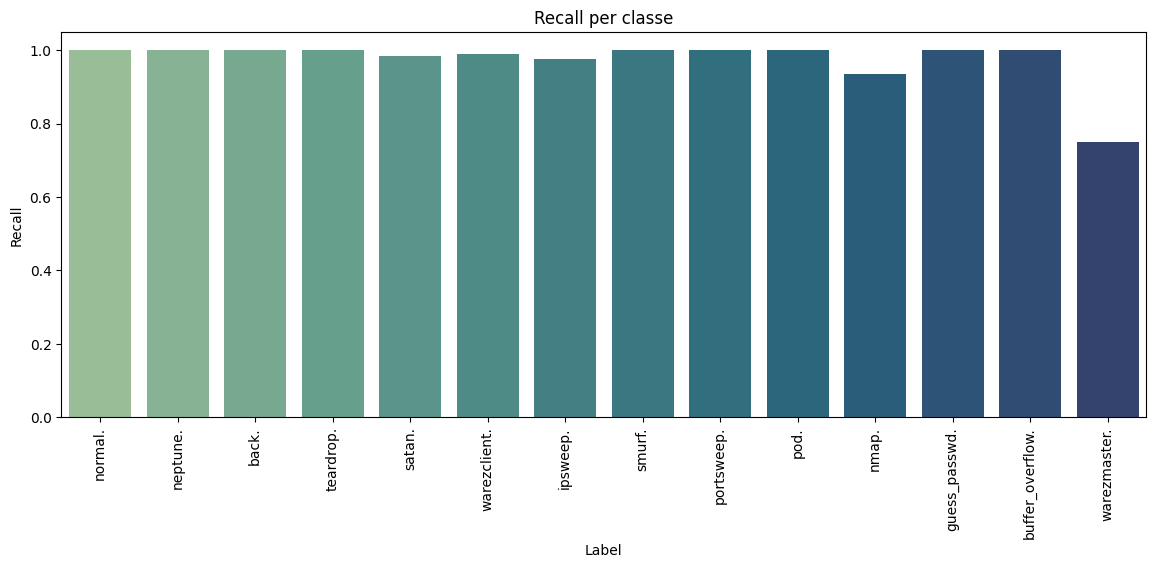

C:\Users\feder\AppData\Local\Temp\ipykernel_18968\2480776343.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Precision', data=results_df, palette="viridis")


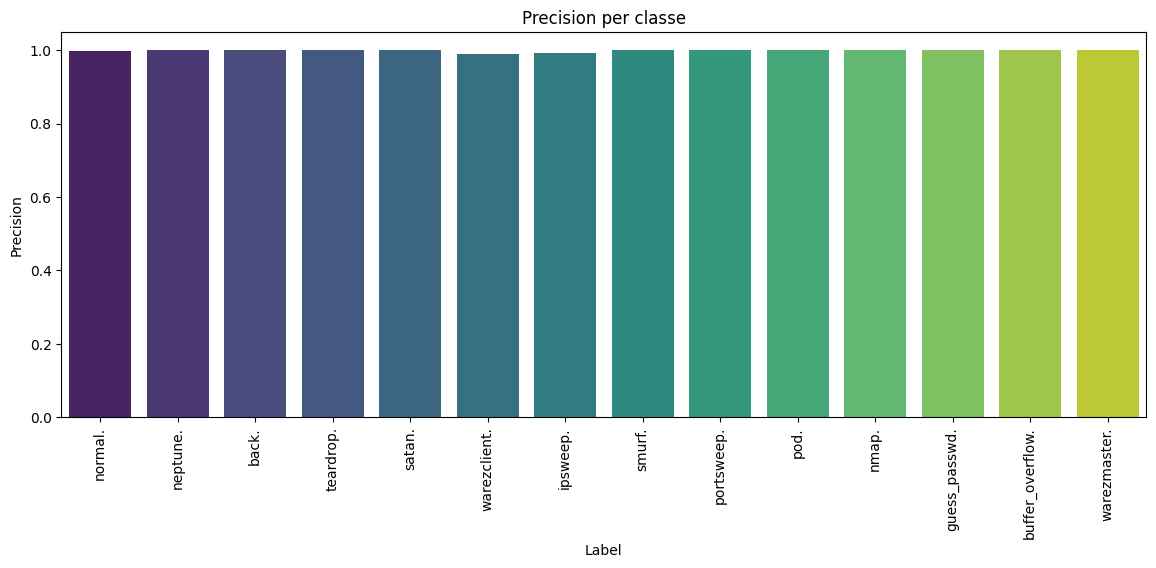

C:\Users\feder\AppData\Local\Temp\ipykernel_18968\2480776343.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='F1', data=results_df, palette="mako")


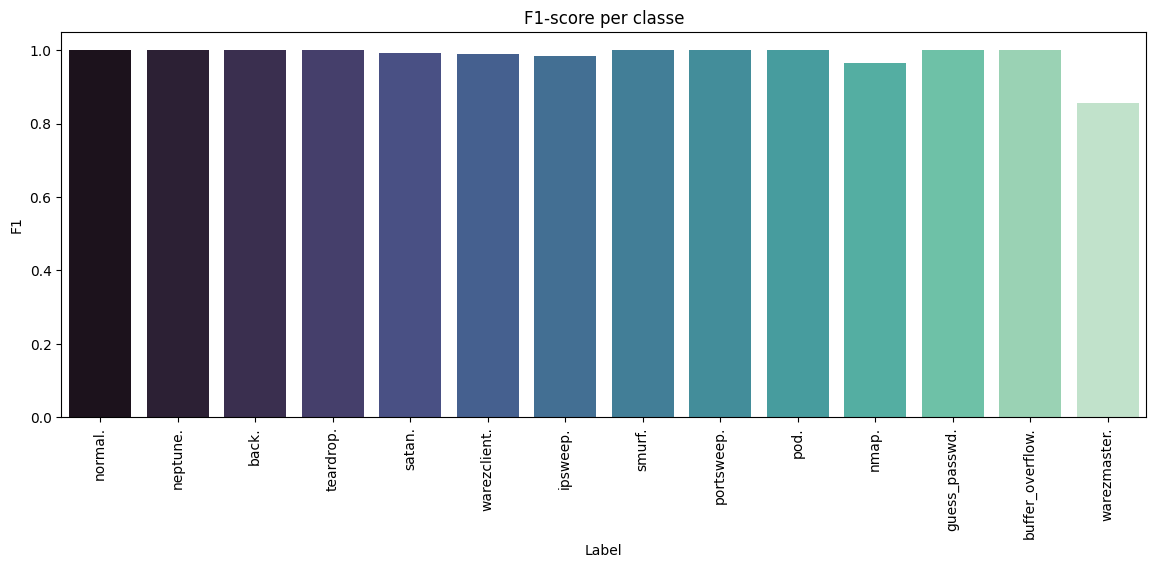

C:\Users\feder\AppData\Local\Temp\ipykernel_18968\2480776343.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Recall', data=results_df, palette="crest")


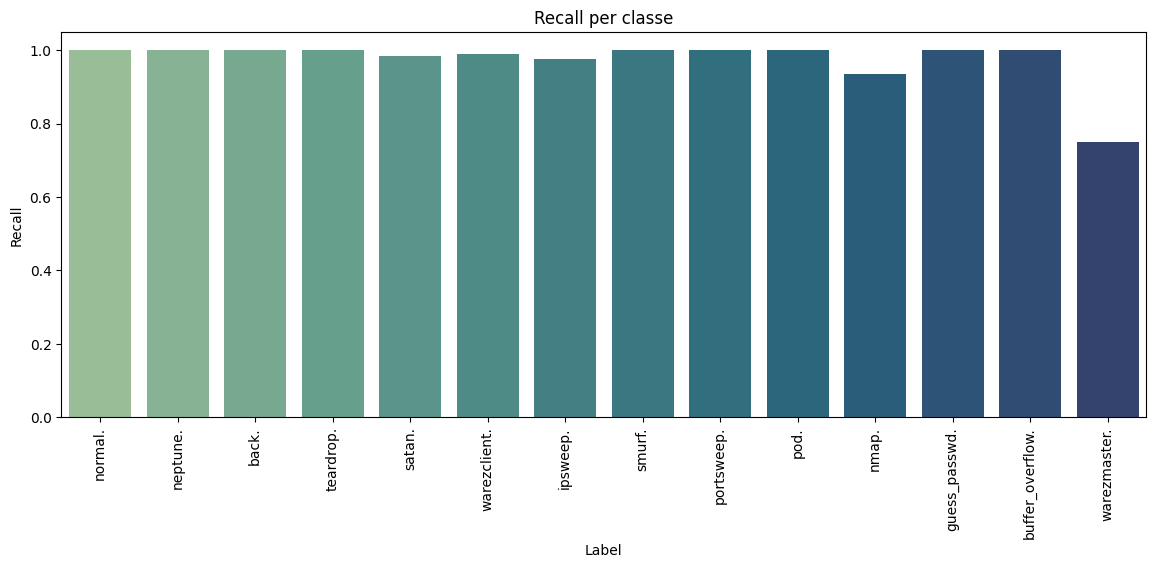

C:\Users\feder\AppData\Local\Temp\ipykernel_18968\2480776343.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Precision', data=results_df, palette="viridis")


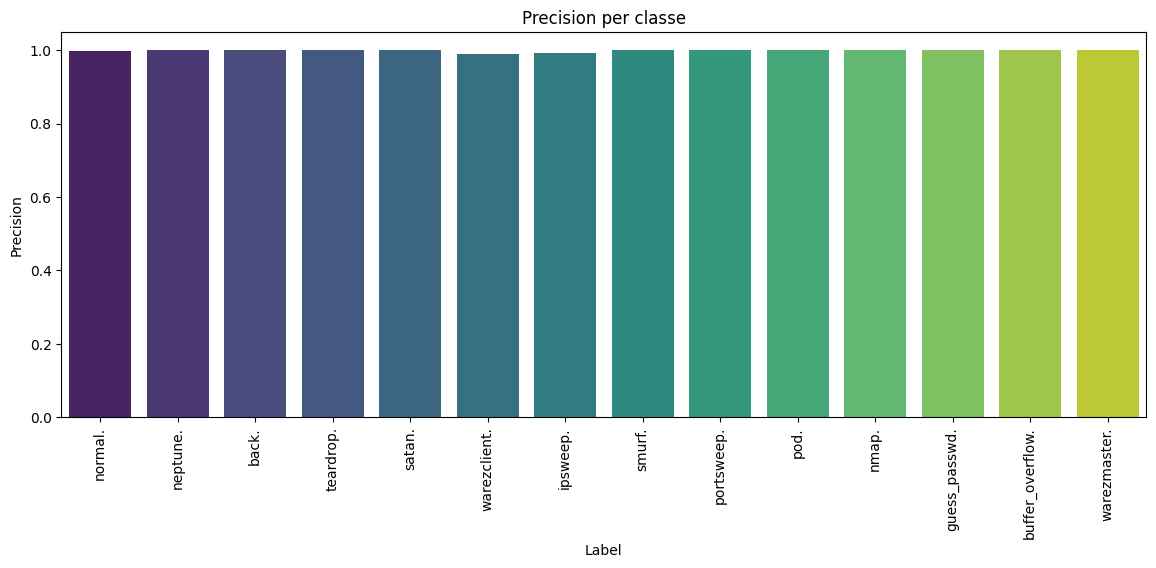

In [21]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=labels_sorted)
results_df = pd.DataFrame({
    'Label': labels_sorted,
    'F1': f1,
    'Precision': precision,
    'Recall': recall,
    'Support': support
})

# Ordina per supporto
results_df = results_df.sort_values('Support', ascending=False)

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='F1', data=results_df, palette="mako")
plt.xticks(rotation=90)
plt.title("F1-score per classe")
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='Recall', data=results_df, palette="crest")
plt.xticks(rotation=90)
plt.title("Recall per classe")
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='Precision', data=results_df, palette="viridis")
plt.xticks(rotation=90)
plt.title("Precision per classe")
plt.show()
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=labels_sorted)
results_df = pd.DataFrame({
    'Label': labels_sorted,
    'F1': f1,
    'Precision': precision,
    'Recall': recall,
    'Support': support
})

# Ordina per supporto
results_df = results_df.sort_values('Support', ascending=False)

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='F1', data=results_df, palette="mako")
plt.xticks(rotation=90)
plt.title("F1-score per classe")
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='Recall', data=results_df, palette="crest")
plt.xticks(rotation=90)
plt.title("Recall per classe")
plt.show()

plt.figure(figsize=(14, 5))
sns.barplot(x='Label', y='Precision', data=results_df, palette="viridis")
plt.xticks(rotation=90)
plt.title("Precision per classe")
plt.show()


### Micro/macro/weighted average

In [22]:
from sklearn.metrics import f1_score

print("F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred, average="weighted"))
print("F1 micro:", f1_score(y_test, y_pred, average="micro"))


F1 macro: 0.984878629960545
F1 weighted: 0.9994800734008116
F1 micro: 0.9994845715071129


### Feature Importance

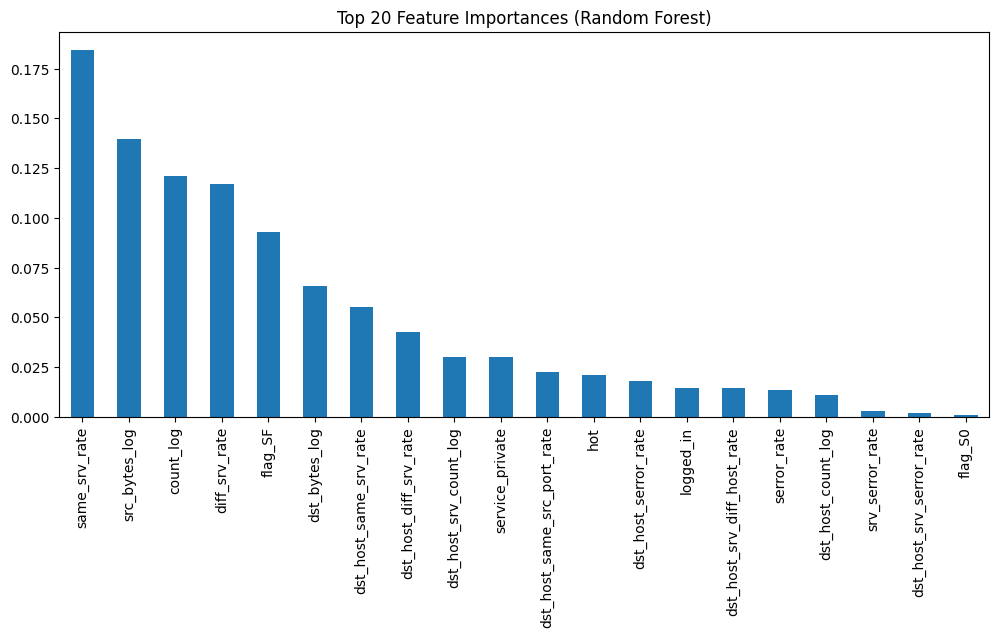

In [25]:
# Recupera il modello dalla pipeline
rf = pipeline.named_steps['rf']
features = pipeline.named_steps['feature_selection'].selected_features_
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(12,5))
feat_imp.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()
